Import the data <br>
Do some minor data visualization <br>
Split the data into training and testing set<br>

<!--Things I need to read up on-->


In [33]:
import numpy as np
import pandas as pd
import csv
from matplotlib import pyplot as plt

#Load the data into a pandas dataFrame
data = pd.read_csv("train.csv")

data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Because I are not using any libraries to train the network, I loaded the data into numpy arrays. These would be used for all the subsequent manipulations. <br>
In this section, I also split the data into training and testing data, did some visualization of the dimensions of the arrays. <br>

Size of numpy array, from data.shape - 42000 x 784, first column corresponds to the labels of the pixels
205% is extracted for the testing set, and the rest is used to train the network


In [34]:
data = np.array(data)
rows, cols = data.shape
print(data.shape)

np.random.shuffle(data)

print(data.shape)

"""
    test_data --> 785, 8400

    test_label_data --> 1, 8400
"""

test_data = data[0:8400].T
test_label_data = test_data[0]
test_pixel_data = test_data[1:]
test_pixel_data = test_pixel_data.astype(float) / 255.0
print(test_data.shape)
print(test_pixel_data.shape)
print(test_label_data.shape)

train_data = data[8400:].T
train_label_data = train_data[0]
train_pixel_data = train_data[1:]
train_pixel_data = train_pixel_data.astype(float) / 255.0
print(train_pixel_data.shape)
print(train_label_data.shape)

(42000, 785)
(42000, 785)
(785, 8400)
(784, 8400)
(8400,)
(784, 33600)
(33600,)


Random weights and biases are initialized. <br>

The Neural Net is a 3-layered neural net. This means we also have 3 sets of weights and biases which we want to optimize, during the training of our neural net.

In [35]:
def initialize_weights_and_biases():
    W1 = np.random.rand(16, 784) - 0.5
    b1 = np.random.rand(16, 1) - 0.5
    
    W2 = np.random.rand(16, 16) - 0.5
    b2 = np.random.rand(16, 1) - 0.5
    
    W3 = np.random.rand(10, 16) - 0.5
    b3 = np.random.rand(10, 1)
    
    return W1, b1, W2, b2, W3, b3

def ReLU(value):
    return np.maximum(0, value)

# def softmax(value):
#     return np.exp(value) / np.sum(np.exp(value))

def softmax(Z):
    # exp_values = np.exp(value)

    # return exp_values / np.sum(exp_values)
    exp = np.exp(Z - np.max(Z)) 
    return exp / exp.sum(axis=0)

def softmax_derivative(value):
    softmax_values = softmax(value)
    diag_softmax = np.diag(softmax_values)
    jacobian_matrix = diag_softmax - np.outer(softmax_values, softmax_values)
    
    return jacobian_matrix


def ReLU_derivative(Z):
    return Z > 0


def forward_propagation(W1, W2, W3, b1, b2, b3, X):
    Z1 = np.matmul(W1, X) + b1
    A1 = ReLU(Z1)

    Z2 = np.matmul(W2, A1) + b2
    A2 = ReLU(Z2)

    Z3 = np.matmul(W3, A2) + b3
    A3 = softmax(Z3)

    return Z1, A1, Z2, A2, Z3, A3

def onehot_encoding(Y):
    output_matrix = np.zeros((Y.size, Y.max() + 1))
    output_matrix[np.arange(Y.size), Y] = 1
    
    return output_matrix.T

def backward_propagation(W1, W2, W3, A1, A2, A3, Z1, Z2, Z3, X, Y):
    output_matrix = onehot_encoding(Y)

    m = len(Y)

    # dA3 = 2 * (output_matrix - A3)
    # dZ3 = np.matmul(dA3, softmax_derivative(Z3))
    dZ3 = A3 - output_matrix
    dW3 = np.matmul(dZ3, A2.T) 
    dW3 = 1 / m * dW3
    db3 = 1 / m * np.sum(dZ3)

    dZ2 = W3.T.dot(dZ3) * ReLU_derivative(Z2)
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)

    dZ1 = W2.T.dot(dZ2) * ReLU_derivative(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)

    return dW1, db1, dW2, db2, dW3, db3



def update_parameters(dW1, db1, dW2, db2, dW3, db3, W1, b1, W2, b2, W3, b3, alpha):
    W1 = W1 - alpha * dW1
    W2 = W2 - alpha * dW2
    W3 = W3 - alpha * dW3
    b1 = b1 - alpha * db1
    b2 = b2 - alpha * db2
    b3 = b3 - alpha * db3

    return W1, b1, W2, b2, W3, b3


In [36]:
def get_predictions(A3):
    return np.argmax(A3, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2, W3, b3 = initialize_weights_and_biases()
    
    for i in range (iterations):
        Z1, A1, Z2, A2, Z3, A3 = forward_propagation(W1, W2, W3, b1, b2, b3, X)
        
        dW1, db1, dW2, db2, dW3, db3 = backward_propagation(W1, W2, W3, A1, A2, A3, Z1, Z2, Z3, X, Y)
        
        W1, b1, W2, b2, W3, b3 = update_parameters(dW1, db1, dW2, db2, dW3, db3, W1, b1, W2, b2, W3, b3, alpha)
        
        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A3)
            print(get_accuracy(predictions, Y))
#             print("/n , -->", Z3.shape, A3.shape)
    
    return W1, b1, W2, b2, W3, b3

In [37]:
W1, b1, W2, b2, W3, b3 = gradient_descent(train_pixel_data, train_label_data, 0.1, 1001)

Iteration:  0
[4 3 0 ... 3 3 3] [0 0 2 ... 6 4 9]
0.09857142857142857
Iteration:  10
[4 3 0 ... 4 4 0] [0 0 2 ... 6 4 9]
0.16220238095238096
Iteration:  20
[5 3 2 ... 4 4 0] [0 0 2 ... 6 4 9]
0.2230952380952381
Iteration:  30
[5 3 2 ... 6 6 0] [0 0 2 ... 6 4 9]
0.2874404761904762
Iteration:  40
[6 3 2 ... 6 6 1] [0 0 2 ... 6 4 9]
0.36086309523809523
Iteration:  50
[6 3 2 ... 6 6 1] [0 0 2 ... 6 4 9]
0.4331845238095238
Iteration:  60
[6 3 2 ... 6 4 0] [0 0 2 ... 6 4 9]
0.5020833333333333
Iteration:  70
[6 3 2 ... 6 4 0] [0 0 2 ... 6 4 9]
0.5630654761904762
Iteration:  80
[5 3 2 ... 6 4 0] [0 0 2 ... 6 4 9]
0.6130059523809523
Iteration:  90
[5 3 2 ... 6 4 0] [0 0 2 ... 6 4 9]
0.6558333333333334
Iteration:  100
[5 3 2 ... 6 4 0] [0 0 2 ... 6 4 9]
0.6866071428571429
Iteration:  110
[5 0 2 ... 6 4 0] [0 0 2 ... 6 4 9]
0.7092559523809524
Iteration:  120
[5 0 2 ... 6 4 0] [0 0 2 ... 6 4 9]
0.72875
Iteration:  130
[5 0 2 ... 6 4 0] [0 0 2 ... 6 4 9]
0.7429761904761905
Iteration:  140
[6 0 2 ..

In [38]:
def make_predictions(X, W1, b1, W2, b2, W3, b3):
    _, _, _, _, _, A3 = forward_propagation(W1, W2, W3, b1, b2, b3, X)
    predictions = get_predictions(A3)
    return predictions

def test_prediction(index, W1, b1, W2, b2, W3, b3):
    current_image = train_pixel_data[:, index, None]
    prediction = make_predictions(train_pixel_data[:, index, None], W1, b1, W2, b2, W3, b3)
    label = train_label_data[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [0]
Label:  0


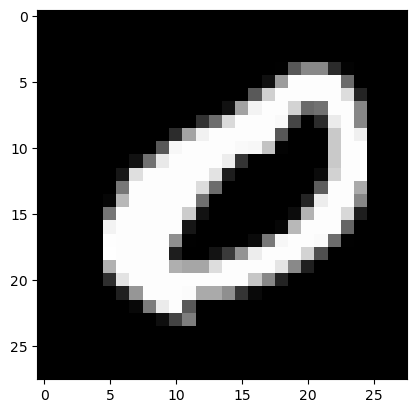

Prediction:  [0]
Label:  0


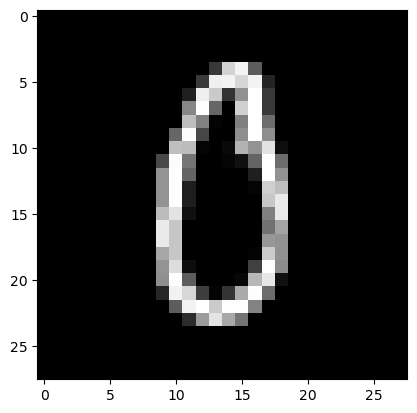

Prediction:  [2]
Label:  2


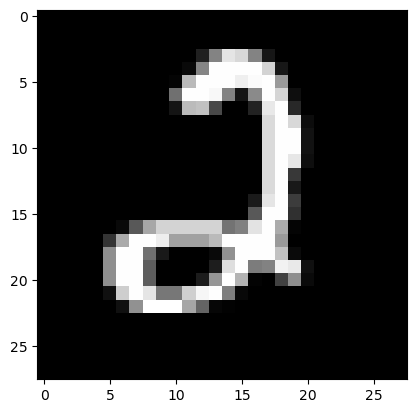

Prediction:  [0]
Label:  0


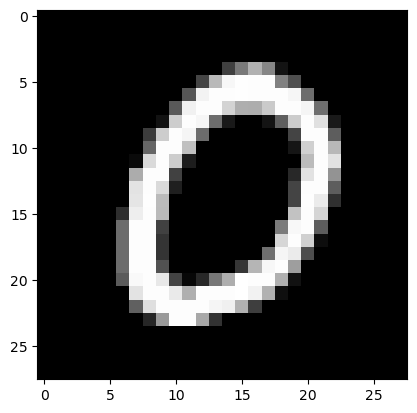

In [39]:
test_prediction(0, W1, b1, W2, b2, W3, b3)
test_prediction(1, W1, b1, W2, b2, W3, b3)
test_prediction(2, W1, b1, W2, b2, W3, b3)
test_prediction(3, W1, b1, W2, b2, W3, b3)

In [40]:
dev_predictions = make_predictions(test_pixel_data, W1, b1, W2, b2, W3, b3)
get_accuracy(dev_predictions, test_label_data)

[0 2 7 ... 1 1 3] [0 2 7 ... 1 1 3]


0.8928571428571429

In [44]:
test_data = pd.read_csv('test.csv')
test_data = test_data.T
predictions = make_predictions(test_data, W1, b1, W2, b2, W3, b3)

csv_file_path = 'submission.csv'

with open(csv_file_path, 'w', newline='') as csvfile:
    # Create a CSV writer object
    csv_writer = csv.writer(csvfile)

    # Write the header
    csv_writer.writerow(['ImageId', 'label'])

    # Write the data
    for idx, value in enumerate(predictions):
        csv_writer.writerow([idx + 1, value])